# Dataset Validation Testing

This notebook uses a dataset [here](https://kilthub.cmu.edu/articles/dataset/eVTOL_Battery_Dataset/14226830) to validate the model.

This notebook is used to test features of the **CloudBFG algorithm** against **real-world data**, collected by an **external source**.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import requests
import progressbar


In [2]:
# start by downloading and extracting the dataset if not already downloaded
dataset_link = 'https://kilthub.cmu.edu/ndownloader/articles/14226830/versions/1'
filename = 'res/14226830.zip'
dataset_path = 'res/dataset'
if not os.path.exists(filename):
    print('Downloading dataset...')
    with requests.get(dataset_link, stream=True) as r:
        total_len = int(r.headers.get('Content-Length'))
        with open(filename, 'wb') as f:
            bar = progressbar.ProgressBar(max_value=total_len)
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    bar.update(f.tell())
            bar.finish()
    print('Download complete.')
else:
    print('Dataset already downloaded.')
if not os.path.exists(dataset_path):
    print('Extracting dataset...')
    os.mkdir(dataset_path)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print('Extraction complete.')
else:
    print('Dataset already extracted.')


Dataset already downloaded.
Dataset already extracted.


The dataset csv files are as follows:

| File Name | Description |
| --------- | ----------- |
|VAH01.csv| Baseline 
|VAH02.csv| Extended cruise (1000 sec)|
|VAH05.csv| 10% power reduction during discharge (flight)|
|VAH06.csv| CC charge current reduced to C/2|
|VAH07.csv| CV charge voltage reduced to 4.0V|
|VAH09.csv| Thermal chamber temperature of 20 degrees C|
|VAH10.csv| Thermal chamber temperature of 30 degrees C|
|VAH11.csv| 20% power reduction during discharge (flight)|
|VAH12.csv| Short cruise length (400 sec)|
|VAH13.csv| Short cruise length (600 sec)|
|VAH15.csv| Extended cruise (1000 sec)|
|VAH16.csv| CC charge current reduced to 1.5C|
|VAH17.csv| Baseline|
|VAH20.csv| Charge current reduced to 1.5C|
|VAH22.csv| Extended cruise (1000 sec)|
|VAH23.csv| CV charge voltage reduced to 4.1V|
|VAH24.csv| CC charge current reduced to C/2|
|VAH25.csv| Thermal chamber temperature of 20 degrees C|
|VAH26.csv| Short cruise length (600 sec)|
|VAH27.csv| Baseline|
|VAH28.csv| 10% power reduction during discharge (flight)|
|VAH30.csv| Thermal chamber temperature of 35 degrees C |

Each dataset has the following columns:

| Column Name | Description |
| ----------- | ----------- |
| time_s | Time since beginning of experiment in seconds|
| Ecell_V | Cell Voltage|
| I_mA | Cell current in milliamperes|
| EnergyCharge_W_h | The amount of energy supplied to the cell during charge in watt-hours|
| QCharge_mA_h | The amout of charge supplied to the cell during charge in milliampere-hours|
| EnergyDischarge_W_h | The amount of energy extracted from the cell during discharge in watt-hours|
| QDischarge_mA_h | The amount of charge extracted from the cell during discharge in milliampere-hours|
| Temperature__C | Cell surface temperature in degrees celcius|
| cycleNumber | Cycle number as recorded by the cell tester (see above note)|
| Ns | Cycle segment (varies, useful for discerning between segments) |

In [3]:
# import the data into dataframes
print('Importing data...')
df = pd.read_csv(os.path.join(dataset_path, 'VAH12.csv'))
print('Import complete.')
# truncate the dataframe so I can do calculations in a reasonable amount of time
df = df.iloc[:20000, :]


Importing data...
Import complete.


Plotting data...


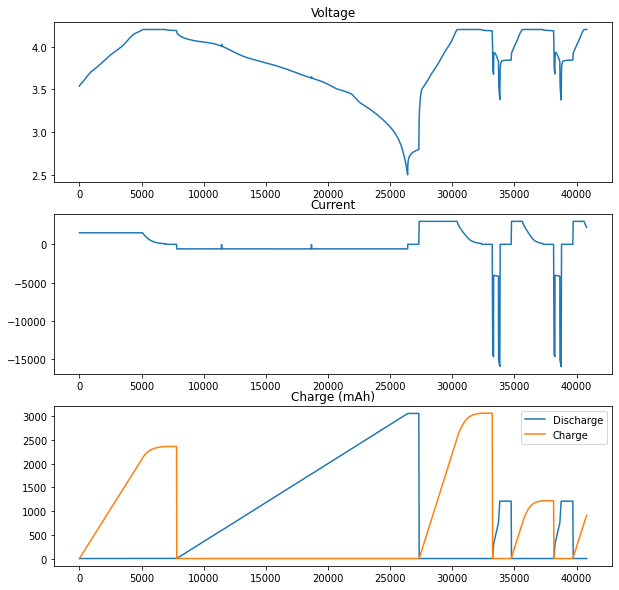

In [4]:
# plot voltage, current, and power over time
print('Plotting data...')
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(df['time_s'], df['Ecell_V'])
ax[0].set_title('Voltage')
ax[1].plot(df['time_s'], df['I_mA'])
ax[1].set_title('Current')
ax[2].plot(df['time_s'], df['QDischarge_mA_h'], label='Discharge')
ax[2].plot(df['time_s'], df['QCharge_mA_h'], label='Charge')
ax[2].set_title('Charge (mAh)')
ax[2].legend()
plt.show()


R0 = 0.04054799438824497


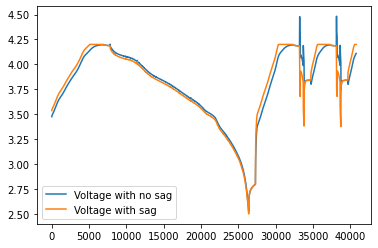

In [5]:
# Now that we have imported relevant data and we can see it, we can start to analyze it.
from estimation import estimate_R0

df['I_A'] = df['I_mA'] / 1000
R0 = estimate_R0(np.array(df['Ecell_V']), np.array(df['I_A']))
print('R0 = {}'.format(R0))

# use R0 and the current to calculate voltage with no sag
df['V_no_sag'] = df['Ecell_V'] - R0 * df['I_A']

# plot voltage with no sag over time against voltage with sag over time
plt.plot(df['time_s'], df['V_no_sag'], label='Voltage with no sag')
plt.plot(df['time_s'], df['Ecell_V'], label='Voltage with sag')
plt.legend()
plt.show()


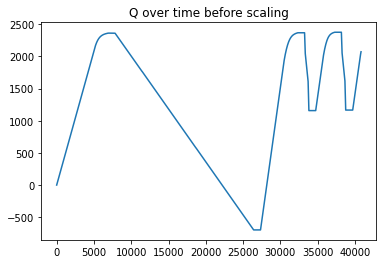

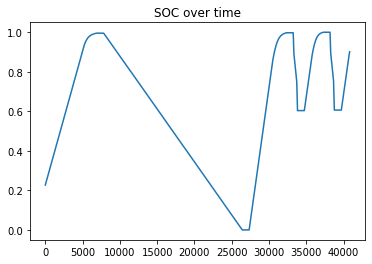

C = 0.001 Ah


In [6]:
# Determine SOC through the entire dataset

# TODO: this shit doesnt work, it skews the soc over time

# use Q_Discharge and Q_Charge to determine SOC
Q_Discharge = np.zeros(len(df['time_s']))
Q_Charge = np.zeros(len(df['time_s']))
for i in range(1, len(df['time_s'])):
    dc_diff = df['QDischarge_mA_h'][i] - df['QDischarge_mA_h'][i-1]
    Q_Discharge[i] = Q_Discharge[i-1] + \
        dc_diff if dc_diff > 0 else Q_Discharge[i-1]
    ch_diff = df['QCharge_mA_h'][i] - df['QCharge_mA_h'][i-1]
    Q_Charge[i] = Q_Charge[i-1] + ch_diff if ch_diff > 0 else Q_Charge[i-1]
Q_total = Q_Charge - Q_Discharge

# plot SOC over time
plt.plot(df['time_s'], Q_total)
plt.title('Q over time before scaling')
plt.show()

# scale Q_total so it ranges from 0 to 1
Q_total = Q_total - Q_total.min()
df['Q_total'] = Q_total
Q_total = Q_total / Q_total.max()
df['SOC'] = Q_total

plt.plot(df['time_s'], df['SOC'])
plt.title('SOC over time')
plt.show()

# C is the capacity of the battery in Ah, which will be the max value in QDischarge_mA_h and QCharge_mA_h
# Since determine_soc() assumes SOC=1, we need to find the maximum charged point, assume that is fully charged, and then use that to offset the error from SOC=1 at the beginning
print(f'C = {round(Q_total.max() / 1000, 3)} Ah')


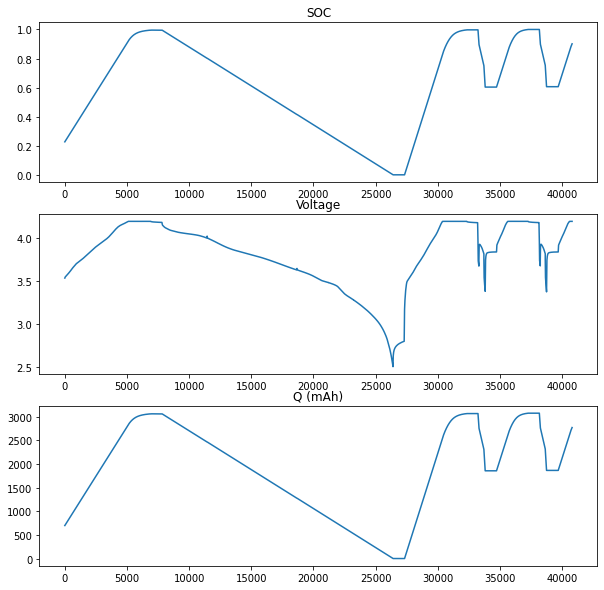

In [7]:
# plot SOC vs Voltage over time
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(df['time_s'], df['SOC'])
ax[0].set_title('SOC')
ax[1].plot(df['time_s'], df['Ecell_V'])
ax[1].set_title('Voltage')
ax[2].plot(df['time_s'], df['Q_total'])
ax[2].set_title('Q (mAh)')
plt.show()


In [8]:
# estimate k-parameters using least squares

# use least squares to estimate k-parameters
from numpy.linalg import lstsq


def combined3(soc: np.ndarray) -> np.ndarray:
    # V = k0 * 1 + k1 * 1/soc + k2 * soc + k3 / soc ^ 2 + k4 / soc ^ 3 + k5 / soc ^ 4 + k6 * ln(soc) + k7 * ln(1 - soc)
    def __scaling_fwd(x, x_min, x_max, E):
        return (1 - 2 * E) * (x - x_min) / (x_max - x_min) + E
    ones = np.ones(len(soc))
    soc = __scaling_fwd(soc, 0, 1, 0.175)
    return np.array([ones, 1 / soc, 1 / soc ** 2, 1 / soc ** 3, 1 / soc ** 4, soc, np.log(soc), np.log(1 - soc)]).T


k_para = np.array(lstsq(combined3(df['SOC']), df['V_no_sag'], rcond=None)[0])
print('lstsq: {}'.format(k_para))


lstsq: [-5.73286701e+00 -8.85338657e+00  5.12902458e-01  3.65253149e-02
 -5.88087763e-03  2.05328116e+01 -2.19197754e+01  7.65190843e-01]


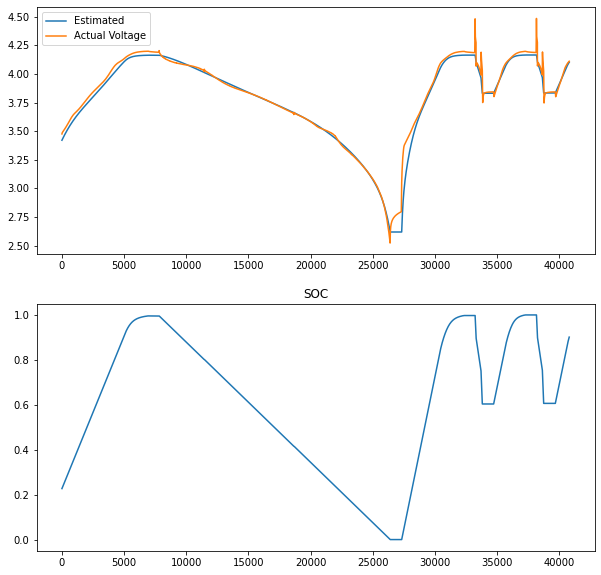

In [9]:
# now, use the SOC collected and the k-parameters to estimate the voltage
Vo = np.sum(combined3(df['SOC']) * k_para, axis=1)
df['Vo'] = Vo

# plot the estimated voltage over time
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df['time_s'], Vo, label='Estimated')
ax[0].plot(df['time_s'], df['V_no_sag'], label='Actual Voltage')
ax[0].legend()
ax[1].plot(df['time_s'], df['SOC'])
ax[1].set_title('SOC')
plt.show()


In [10]:
# start by defining each of the modelling errors
from numpy.linalg import norm

"""
v = actual/target voltage
vh = v hat = estimated voltage
k = k-parameters
"""


def BF(v: np.ndarray, vh: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    best fit error %
    """
    vb = np.sum(vh)
    return (1 - norm(vh - v) / norm(v - vb)) * 100


def R2(v: np.ndarray, vh: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    R2 fit error %
    """
    vb = np.mean(vh)
    return (1 - np.square(norm(vh - v)) / np.square(norm(v - vb))) * 100


def ME(v: np.ndarray, vh: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    max error
    """
    return np.max(np.abs(v - vh))


def RMS(v: np.ndarray, vh: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    RMS error
    """
    N = len(v)
    M = len(k)
    return norm(v - vh) / np.sqrt(N-M)


def AIC(v: np.ndarray, vh: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Akaike information criterion
    """
    N = len(v)
    M = len(k)
    return N * np.log(np.sum(np.square(v-vh))/N) + 2 * (M+1)


errors = {
    'BF': BF,
    'R2': R2,
    'ME': ME,
    'RMS': RMS,
    'AIC': AIC
}


In [11]:
""" DONT USE THIS FOR NOW """

# use error metrics to gauge accuracy

v = df['V_no_sag']
vh = df['Vo']
k = k_para

e = {name: e(v, vh, k_para) for name, e in errors.items()}

print('error metrics:')
for error, modelss in e.items():
    print(f'  {error.rjust(5)} : {round(modelss, 3)}')


error metrics:
     BF : 100.0
     R2 : 99.602
     ME : 0.443
    RMS : 0.023
    AIC : -151239.674


In [12]:
# define the soc estimation algorithm
from estimation import estimate_soc


/ |#                                                  | 0 Elapsed Time: 0:00:00
- | #                                               | 372 Elapsed Time: 0:00:00
\ |  #                                              | 868 Elapsed Time: 0:00:00
| |   #                                            | 1388 Elapsed Time: 0:00:00
/ |    #                                           | 1913 Elapsed Time: 0:00:00
- |     #                                          | 2463 Elapsed Time: 0:00:00
\ |      #                                         | 3009 Elapsed Time: 0:00:00
| |       #                                        | 3572 Elapsed Time: 0:00:00
/ |        #                                       | 4127 Elapsed Time: 0:00:00
- |         #                                      | 4660 Elapsed Time: 0:00:00
\ |          #                                     | 5027 Elapsed Time: 0:00:01
| |           #                                    | 5530 Elapsed Time: 0:00:01
/ |            #                        

avg error: 0.9601482117758992%
max error: 26.827724600590386%
median error: 0.5334978964624232%


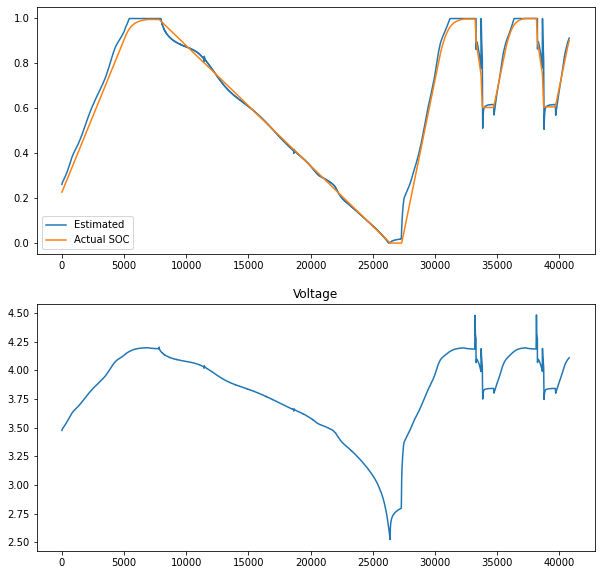

In [13]:
# test soc estimation using known soc from coulomb counting and the k-parameters

# print(k_para)
# soc_est = [estimate_soc(Vo, k_para) for Vo in progressbar.progressbar(df['V_no_sag'])]
soc_est = []
for i, Vo in progressbar.progressbar(enumerate(df['V_no_sag'])):
    soc_est.append(estimate_soc(Vo, k_para))

# gauge how accurate the soc estimation is
diff = np.abs(np.array(soc_est) - np.array(df.SOC))
print(f'avg error: {np.mean(diff) * 100}%')
print(f'max error: {np.max(diff) * 100}%')
print(f'median error: {np.median(diff) * 100}%')

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df['time_s'], soc_est, label='Estimated')
ax[0].plot(df['time_s'], df['SOC'], label='Actual SOC')
ax[0].legend()
ax[1].plot(df['time_s'], df['V_no_sag'])
ax[1].set_title('Voltage')
plt.show()


